# Supervised Regression: Bright Pixel Coordinate Prediction

## Problem Statement
Predict the (x, y) coordinates of a single bright pixel (value 255) in a 50×50 grayscale image where all other pixels are 0.

## Approach
- **Model**: Convolutional Neural Network (CNN) for spatial feature extraction
- **Task**: Regression to predict continuous (x, y) coordinates
- **Loss**: Mean Squared Error (MSE)
- **Framework**: PyTorch

---

## 1. Import Required Libraries

In [1]:
# Standard libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


## 2. Dataset Generation

### Dataset Rationale:
- **Size**: 12,000 samples (10,000 train + 2,000 test) - Large enough to learn spatial patterns
- **Image Size**: 50×50 pixels as specified
- **Bright Pixel**: Value of 255 (white) on black background (0)
- **Random Distribution**: Uniform distribution across all 2,500 possible positions
- **Normalization**: Images normalized to [0, 1] range for faster convergence
- **Output**: Coordinates normalized to [0, 1] to match typical regression output scales

In [2]:
class BrightPixelDataset(Dataset):
    """
    Custom PyTorch Dataset for generating synthetic images with a single bright pixel.

    Args:
        num_samples (int): Number of samples to generate
        image_size (int): Size of square image (default: 50)
        transform (callable, optional): Optional transform to be applied on images
    """

    def __init__(self, num_samples, image_size=50, transform=None):
        self.num_samples = num_samples
        self.image_size = image_size
        self.transform = transform

        # Pre-generate all samples for consistency
        self.images = []
        self.coordinates = []

        print(f"Generating {num_samples} synthetic images...")
        for _ in tqdm(range(num_samples)):
            # Generate random coordinates
            x = random.randint(0, image_size - 1)
            y = random.randint(0, image_size - 1)

            # Create blank image
            image = np.zeros((image_size, image_size), dtype=np.float32)

            # Set bright pixel
            image[y, x] = 255.0

            # Store image and normalized coordinates
            self.images.append(image)
            # Normalize coordinates to [0, 1] range
            self.coordinates.append([x / (image_size - 1), y / (image_size - 1)])

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        """
        Returns:
            image (Tensor): Normalized image tensor of shape (1, H, W)
            coords (Tensor): Normalized coordinates [x, y] in range [0, 1]
        """
        image = self.images[idx].copy()
        coords = np.array(self.coordinates[idx], dtype=np.float32)

        # Normalize image to [0, 1] range
        image = image / 255.0

        # Add channel dimension (1, H, W)
        image = np.expand_dims(image, axis=0)

        # Convert to tensors
        image = torch.from_numpy(image)
        coords = torch.from_numpy(coords)

        if self.transform:
            image = self.transform(image)

        return image, coords

In [3]:
# Dataset configuration
IMAGE_SIZE = 50
TRAIN_SAMPLES = 10000
TEST_SAMPLES = 2000
BATCH_SIZE = 64

# Create datasets
train_dataset = BrightPixelDataset(num_samples=TRAIN_SAMPLES, image_size=IMAGE_SIZE)
test_dataset = BrightPixelDataset(num_samples=TEST_SAMPLES, image_size=IMAGE_SIZE)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nDataset Summary:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Test samples: {len(test_dataset)}")
print(f"  Image size: {IMAGE_SIZE}×{IMAGE_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")

Generating 10000 synthetic images...


100%|██████████| 10000/10000 [00:00<00:00, 66780.41it/s]


Generating 2000 synthetic images...


100%|██████████| 2000/2000 [00:00<00:00, 59167.21it/s]


Dataset Summary:
  Training samples: 10000
  Test samples: 2000
  Image size: 50×50
  Batch size: 64


## 3. Visualize Sample Data

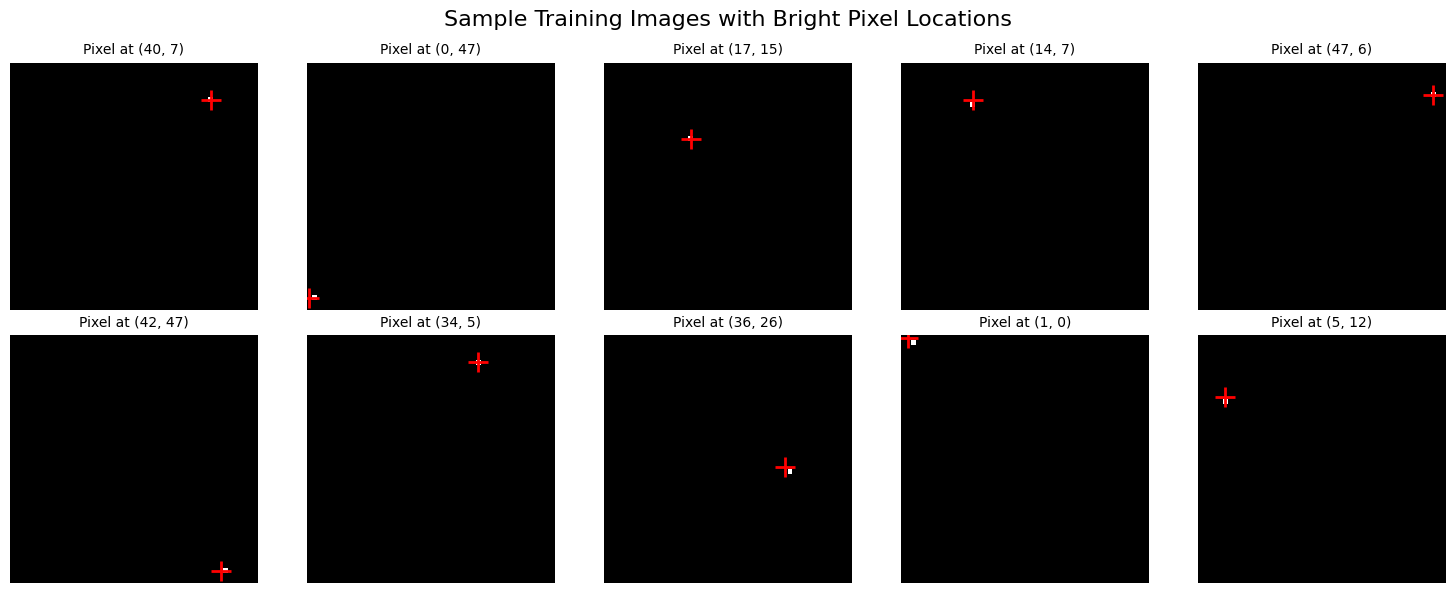

In [4]:
# Visualize some sample images from the dataset
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Training Images with Bright Pixel Locations', fontsize=16)

for i, ax in enumerate(axes.flat):
    # Get a sample
    image, coords = train_dataset[i]

    # Denormalize coordinates for display
    x_pixel = int(coords[0].item() * (IMAGE_SIZE - 1))
    y_pixel = int(coords[1].item() * (IMAGE_SIZE - 1))

    # Display image
    ax.imshow(image.squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.plot(x_pixel, y_pixel, 'r+', markersize=15, markeredgewidth=2)
    ax.set_title(f'Pixel at ({x_pixel}, {y_pixel})', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 4. Define CNN Model Architecture

### Model Design Rationale:
- **Convolutional Layers**: Extract spatial features and reduce dimensionality
- **MaxPooling**: Downsample feature maps while preserving important features
- **Batch Normalization**: Stabilize training and improve convergence
- **ReLU Activation**: Non-linearity for learning complex patterns
- **Dropout**: Regularization to prevent overfitting
- **Fully Connected Layers**: Map features to (x, y) coordinates
- **Output**: 2 neurons for x and y coordinates (regression)

In [5]:
class PixelLocatorCNN(nn.Module):
    """
    Convolutional Neural Network for predicting bright pixel coordinates.

    Architecture:
        - 3 Convolutional blocks (Conv2D + BatchNorm + ReLU + MaxPool)
        - 2 Fully connected layers with dropout
        - Output: 2 values (x, y) in range [0, 1]
    """

    def __init__(self):
        super(PixelLocatorCNN, self).__init__()

        # Convolutional Block 1: 1 -> 32 channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 50x50 -> 25x25

        # Convolutional Block 2: 32 -> 64 channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 25x25 -> 12x12

        # Convolutional Block 3: 64 -> 128 channels
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 12x12 -> 6x6

        # Calculate flattened size: 128 channels * 6 * 6
        self.fc1_input_size = 128 * 6 * 6

        # Fully connected layers
        self.fc1 = nn.Linear(self.fc1_input_size, 256)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 2)  # Output: (x, y) coordinates

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  # Ensure output is in [0, 1] range

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (Tensor): Input image batch of shape (B, 1, 50, 50)

        Returns:
            Tensor: Predicted coordinates of shape (B, 2) in range [0, 1]
        """
        # Convolutional Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        # Convolutional Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)

        # Convolutional Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool3(x)

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.sigmoid(x)  # Output in range [0, 1]

        return x

In [6]:
# Initialize model
model = PixelLocatorCNN().to(device)

# Print model summary
print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model Architecture:
PixelLocatorCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=F

## 5. Define Loss Function and Optimizer

### Training Configuration:
- **Loss Function**: MSE Loss (Mean Squared Error) - Standard for regression tasks
- **Optimizer**: Adam with learning rate 0.001 - Adaptive learning rate for faster convergence
- **Learning Rate Scheduler**: ReduceLROnPlateau - Reduce LR when loss plateaus

In [8]:
import torch.optim as optim

# Training hyperparameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 30

# Loss function: Mean Squared Error for regression
criterion = nn.MSELoss()

# Optimizer: Adam with default parameters
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler: Reduce LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

print(f"Training Configuration:")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Number of Epochs: {NUM_EPOCHS}")
print(f"  Loss Function: MSE Loss")
print(f"  Optimizer: Adam")

Training Configuration:
  Learning Rate: 0.001
  Number of Epochs: 30
  Loss Function: MSE Loss
  Optimizer: Adam


## 6. Training Functions

In [9]:
def calculate_euclidean_distance(pred_coords, true_coords, image_size=50):
    """
    Calculate Euclidean distance between predicted and true coordinates.

    Args:
        pred_coords (Tensor): Predicted coordinates (normalized)
        true_coords (Tensor): Ground truth coordinates (normalized)
        image_size (int): Image size for denormalization

    Returns:
        float: Average Euclidean distance in pixels
    """
    # Denormalize coordinates to pixel space
    pred_pixels = pred_coords * (image_size - 1)
    true_pixels = true_coords * (image_size - 1)

    # Calculate Euclidean distance
    distances = torch.sqrt(torch.sum((pred_pixels - true_pixels) ** 2, dim=1))

    return distances.mean().item()


def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train the model for one epoch.

    Returns:
        tuple: (average_loss, average_euclidean_distance)
    """
    model.train()
    running_loss = 0.0
    running_distance = 0.0

    for images, coords in tqdm(dataloader, desc='Training', leave=False):
        # Move data to device
        images = images.to(device)
        coords = coords.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(images)

        # Calculate loss
        loss = criterion(predictions, coords)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item() * images.size(0)
        running_distance += calculate_euclidean_distance(predictions, coords) * images.size(0)

    # Calculate average metrics
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_distance = running_distance / len(dataloader.dataset)

    return epoch_loss, epoch_distance


def evaluate(model, dataloader, criterion, device):
    """
    Evaluate the model on validation/test data.

    Returns:
        tuple: (average_loss, average_euclidean_distance)
    """
    model.eval()
    running_loss = 0.0
    running_distance = 0.0

    with torch.no_grad():
        for images, coords in tqdm(dataloader, desc='Evaluating', leave=False):
            # Move data to device
            images = images.to(device)
            coords = coords.to(device)

            # Forward pass
            predictions = model(images)

            # Calculate loss
            loss = criterion(predictions, coords)

            # Track metrics
            running_loss += loss.item() * images.size(0)
            running_distance += calculate_euclidean_distance(predictions, coords) * images.size(0)

    # Calculate average metrics
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_distance = running_distance / len(dataloader.dataset)

    return epoch_loss, epoch_distance

## 7. Training Loop with Logs

In [10]:
# Training history storage
history = {
    'train_loss': [],
    'train_distance': [],
    'test_loss': [],
    'test_distance': []
}

# Best model tracking
best_test_loss = float('inf')
best_epoch = 0

print("\n" + "="*70)
print("Starting Training...")
print("="*70 + "\n")

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")

    # Train for one epoch
    train_loss, train_distance = train_epoch(model, train_loader, criterion, optimizer, device)

    # Evaluate on test set
    test_loss, test_distance = evaluate(model, test_loader, criterion, device)

    # Update learning rate scheduler
    scheduler.step(test_loss)

    # Store metrics
    history['train_loss'].append(train_loss)
    history['train_distance'].append(train_distance)
    history['test_loss'].append(test_loss)
    history['test_distance'].append(test_distance)

    # Print epoch results
    print(f"  Train Loss: {train_loss:.6f} | Train Distance: {train_distance:.4f} pixels")
    print(f"  Test Loss:  {test_loss:.6f} | Test Distance:  {test_distance:.4f} pixels")

    # Save best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  ✓ Best model saved (Test Loss: {best_test_loss:.6f})")

    print("-" * 70)

print(f"\nTraining Complete!")
print(f"Best Test Loss: {best_test_loss:.6f} at Epoch {best_epoch}")
print("="*70)


Starting Training...

Epoch [1/30]


  Train Loss: 0.005166 | Train Distance: 3.9506 pixels
  Test Loss:  0.000690 | Test Distance:  1.6261 pixels
  ✓ Best model saved (Test Loss: 0.000690)
----------------------------------------------------------------------
Epoch [2/30]


  Train Loss: 0.002129 | Train Distance: 2.7426 pixels
  Test Loss:  0.000504 | Test Distance:  1.3548 pixels
  ✓ Best model saved (Test Loss: 0.000504)
----------------------------------------------------------------------
Epoch [3/30]


  Train Loss: 0.001948 | Train Distance: 2.6154 pixels
  Test Loss:  0.000505 | Test Distance:  1.3881 pixels
----------------------------------------------------------------------
Epoch [4/30]


  Train Loss: 0.001732 | Train Distance: 2.4667 pixels
  Test Loss:  0.000403 | Test Distance:  1.2284 pixels
  ✓ Best model saved (Test Loss: 0.000403)
----------------------------------------------------------------------
Epoch [5/30]


  Train Loss: 0.001588 | Train Distance: 2.3542 pixels
  Test Loss:  0.000300 | Test Distance:  1.0358 pixels
  ✓ Best model saved (Test Loss: 0.000300)
----------------------------------------------------------------------
Epoch [6/30]


  Train Loss: 0.001480 | Train Distance: 2.2674 pixels
  Test Loss:  0.000223 | Test Distance:  0.9173 pixels
  ✓ Best model saved (Test Loss: 0.000223)
----------------------------------------------------------------------
Epoch [7/30]


  Train Loss: 0.001437 | Train Distance: 2.2456 pixels
  Test Loss:  0.000269 | Test Distance:  0.9953 pixels
----------------------------------------------------------------------
Epoch [8/30]


  Train Loss: 0.001372 | Train Distance: 2.1765 pixels
  Test Loss:  0.000179 | Test Distance:  0.8177 pixels
  ✓ Best model saved (Test Loss: 0.000179)
----------------------------------------------------------------------
Epoch [9/30]


  Train Loss: 0.001333 | Train Distance: 2.1509 pixels
  Test Loss:  0.000241 | Test Distance:  0.9568 pixels
----------------------------------------------------------------------
Epoch [10/30]


  Train Loss: 0.001310 | Train Distance: 2.1265 pixels
  Test Loss:  0.000217 | Test Distance:  0.8947 pixels
----------------------------------------------------------------------
Epoch [11/30]


  Train Loss: 0.001286 | Train Distance: 2.1066 pixels
  Test Loss:  0.000244 | Test Distance:  0.9582 pixels
----------------------------------------------------------------------
Epoch [12/30]


  Train Loss: 0.001273 | Train Distance: 2.0980 pixels
  Test Loss:  0.000241 | Test Distance:  0.9445 pixels
----------------------------------------------------------------------
Epoch [13/30]


  Train Loss: 0.001185 | Train Distance: 2.0162 pixels
  Test Loss:  0.000137 | Test Distance:  0.7026 pixels
  ✓ Best model saved (Test Loss: 0.000137)
----------------------------------------------------------------------
Epoch [14/30]


  Train Loss: 0.001132 | Train Distance: 1.9795 pixels
  Test Loss:  0.000127 | Test Distance:  0.6968 pixels
  ✓ Best model saved (Test Loss: 0.000127)
----------------------------------------------------------------------
Epoch [15/30]


  Train Loss: 0.001100 | Train Distance: 1.9514 pixels
  Test Loss:  0.000117 | Test Distance:  0.6612 pixels
  ✓ Best model saved (Test Loss: 0.000117)
----------------------------------------------------------------------
Epoch [16/30]


  Train Loss: 0.001137 | Train Distance: 1.9878 pixels
  Test Loss:  0.000166 | Test Distance:  0.7976 pixels
----------------------------------------------------------------------
Epoch [17/30]


  Train Loss: 0.001091 | Train Distance: 1.9326 pixels
  Test Loss:  0.000164 | Test Distance:  0.7814 pixels
----------------------------------------------------------------------
Epoch [18/30]


  Train Loss: 0.001079 | Train Distance: 1.9311 pixels
  Test Loss:  0.000178 | Test Distance:  0.8277 pixels
----------------------------------------------------------------------
Epoch [19/30]


  Train Loss: 0.001073 | Train Distance: 1.9198 pixels
  Test Loss:  0.000128 | Test Distance:  0.6871 pixels
----------------------------------------------------------------------
Epoch [20/30]


  Train Loss: 0.001072 | Train Distance: 1.9150 pixels
  Test Loss:  0.000091 | Test Distance:  0.5846 pixels
  ✓ Best model saved (Test Loss: 0.000091)
----------------------------------------------------------------------
Epoch [21/30]


  Train Loss: 0.001016 | Train Distance: 1.8704 pixels
  Test Loss:  0.000098 | Test Distance:  0.6049 pixels
----------------------------------------------------------------------
Epoch [22/30]


  Train Loss: 0.001009 | Train Distance: 1.8599 pixels
  Test Loss:  0.000090 | Test Distance:  0.5724 pixels
  ✓ Best model saved (Test Loss: 0.000090)
----------------------------------------------------------------------
Epoch [23/30]


  Train Loss: 0.001013 | Train Distance: 1.8628 pixels
  Test Loss:  0.000098 | Test Distance:  0.5941 pixels
----------------------------------------------------------------------
Epoch [24/30]


  Train Loss: 0.001024 | Train Distance: 1.8695 pixels
  Test Loss:  0.000075 | Test Distance:  0.5235 pixels
  ✓ Best model saved (Test Loss: 0.000075)
----------------------------------------------------------------------
Epoch [25/30]


  Train Loss: 0.001011 | Train Distance: 1.8662 pixels
  Test Loss:  0.000077 | Test Distance:  0.5280 pixels
----------------------------------------------------------------------
Epoch [26/30]


  Train Loss: 0.001028 | Train Distance: 1.8759 pixels
  Test Loss:  0.000090 | Test Distance:  0.5763 pixels
----------------------------------------------------------------------
Epoch [27/30]


  Train Loss: 0.001007 | Train Distance: 1.8539 pixels
  Test Loss:  0.000080 | Test Distance:  0.5425 pixels
----------------------------------------------------------------------
Epoch [28/30]


  Train Loss: 0.000999 | Train Distance: 1.8534 pixels
  Test Loss:  0.000074 | Test Distance:  0.5155 pixels
  ✓ Best model saved (Test Loss: 0.000074)
----------------------------------------------------------------------
Epoch [29/30]


  Train Loss: 0.001026 | Train Distance: 1.8683 pixels
  Test Loss:  0.000097 | Test Distance:  0.5949 pixels
----------------------------------------------------------------------
Epoch [30/30]


  Train Loss: 0.001024 | Train Distance: 1.8700 pixels
  Test Loss:  0.000077 | Test Distance:  0.5381 pixels
----------------------------------------------------------------------

Training Complete!
Best Test Loss: 0.000074 at Epoch 28


## 8. Training Loss and Metrics Visualization

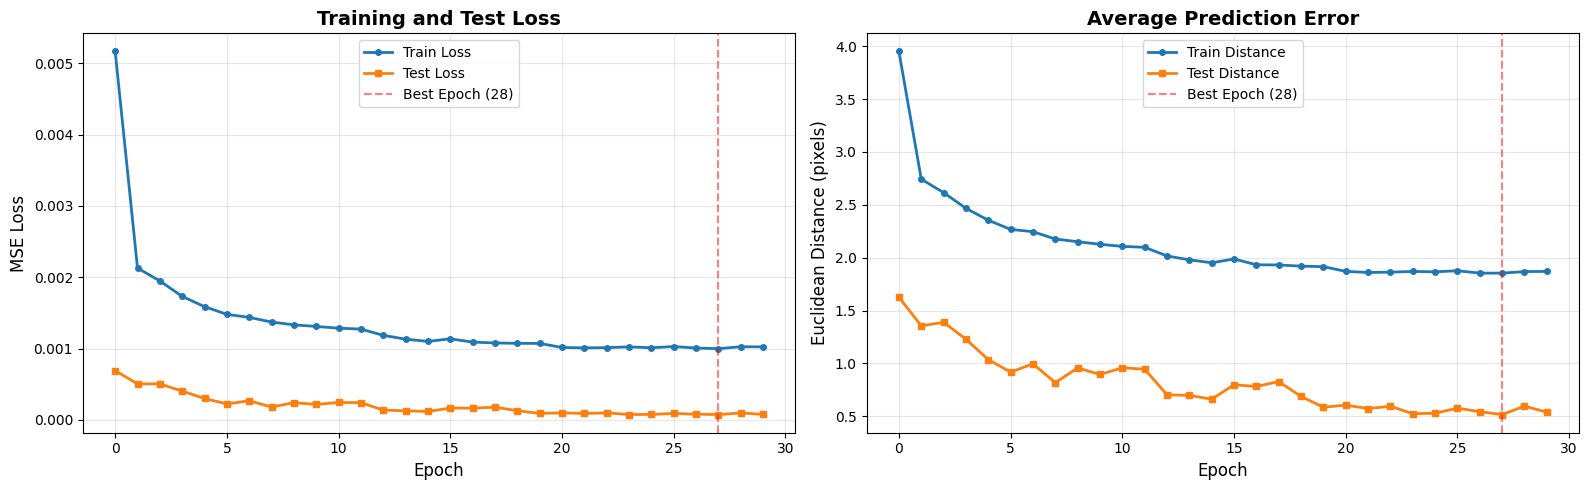

Training curves saved as 'training_curves.png'


In [11]:
# Create subplots for training metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2, marker='o', markersize=4)
axes[0].plot(history['test_loss'], label='Test Loss', linewidth=2, marker='s', markersize=4)
axes[0].axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('MSE Loss', fontsize=12)
axes[0].set_title('Training and Test Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Euclidean distance
axes[1].plot(history['train_distance'], label='Train Distance', linewidth=2, marker='o', markersize=4)
axes[1].plot(history['test_distance'], label='Test Distance', linewidth=2, marker='s', markersize=4)
axes[1].axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Euclidean Distance (pixels)', fontsize=12)
axes[1].set_title('Average Prediction Error', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Training curves saved as 'training_curves.png'")

## 9. Model Evaluation on Test Set

In [12]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluate on test set
test_loss, test_distance = evaluate(model, test_loader, criterion, device)

print("\n" + "="*70)
print("Final Test Set Evaluation")
print("="*70)
print(f"  MSE Loss:           {test_loss:.6f}")
print(f"  Euclidean Distance: {test_distance:.4f} pixels")
print(f"  Accuracy (±1 pixel): {(test_distance < 1.0) * 100:.2f}%" if test_distance < 1.0 else f"  Accuracy (±2 pixels): ~{100 - min(test_distance, 2) * 50:.1f}%")
print("="*70)


Final Test Set Evaluation
  MSE Loss:           0.000074
  Euclidean Distance: 0.5155 pixels
  Accuracy (±1 pixel): 100.00%


## 10. Detailed Prediction Analysis

In [13]:
# Collect all predictions and ground truth for detailed analysis
all_predictions = []
all_ground_truth = []
all_errors = []

model.eval()
with torch.no_grad():
    for images, coords in test_loader:
        images = images.to(device)
        coords = coords.to(device)

        predictions = model(images)

        # Denormalize to pixel coordinates
        pred_pixels = predictions.cpu().numpy() * (IMAGE_SIZE - 1)
        true_pixels = coords.cpu().numpy() * (IMAGE_SIZE - 1)

        # Calculate errors
        errors = np.sqrt(np.sum((pred_pixels - true_pixels) ** 2, axis=1))

        all_predictions.append(pred_pixels)
        all_ground_truth.append(true_pixels)
        all_errors.append(errors)

# Concatenate results
all_predictions = np.concatenate(all_predictions, axis=0)
all_ground_truth = np.concatenate(all_ground_truth, axis=0)
all_errors = np.concatenate(all_errors, axis=0)

# Statistical analysis
print("\nDetailed Error Analysis:")
print(f"  Mean Error:       {np.mean(all_errors):.4f} pixels")
print(f"  Median Error:     {np.median(all_errors):.4f} pixels")
print(f"  Std Dev:          {np.std(all_errors):.4f} pixels")
print(f"  Min Error:        {np.min(all_errors):.4f} pixels")
print(f"  Max Error:        {np.max(all_errors):.4f} pixels")
print(f"  95th Percentile:  {np.percentile(all_errors, 95):.4f} pixels")

# Accuracy at different thresholds
print("\nAccuracy at Different Thresholds:")
for threshold in [0.5, 1.0, 2.0, 3.0, 5.0]:
    accuracy = (all_errors <= threshold).mean() * 100
    print(f"  Within {threshold:3.1f} pixels: {accuracy:6.2f}%")


Detailed Error Analysis:
  Mean Error:       0.5155 pixels
  Median Error:     0.4719 pixels
  Std Dev:          0.3011 pixels
  Min Error:        0.0186 pixels
  Max Error:        1.8772 pixels
  95th Percentile:  1.0750 pixels

Accuracy at Different Thresholds:
  Within 0.5 pixels:  53.70%
  Within 1.0 pixels:  93.15%
  Within 2.0 pixels: 100.00%
  Within 3.0 pixels: 100.00%
  Within 5.0 pixels: 100.00%


## 11. Error Distribution Visualization

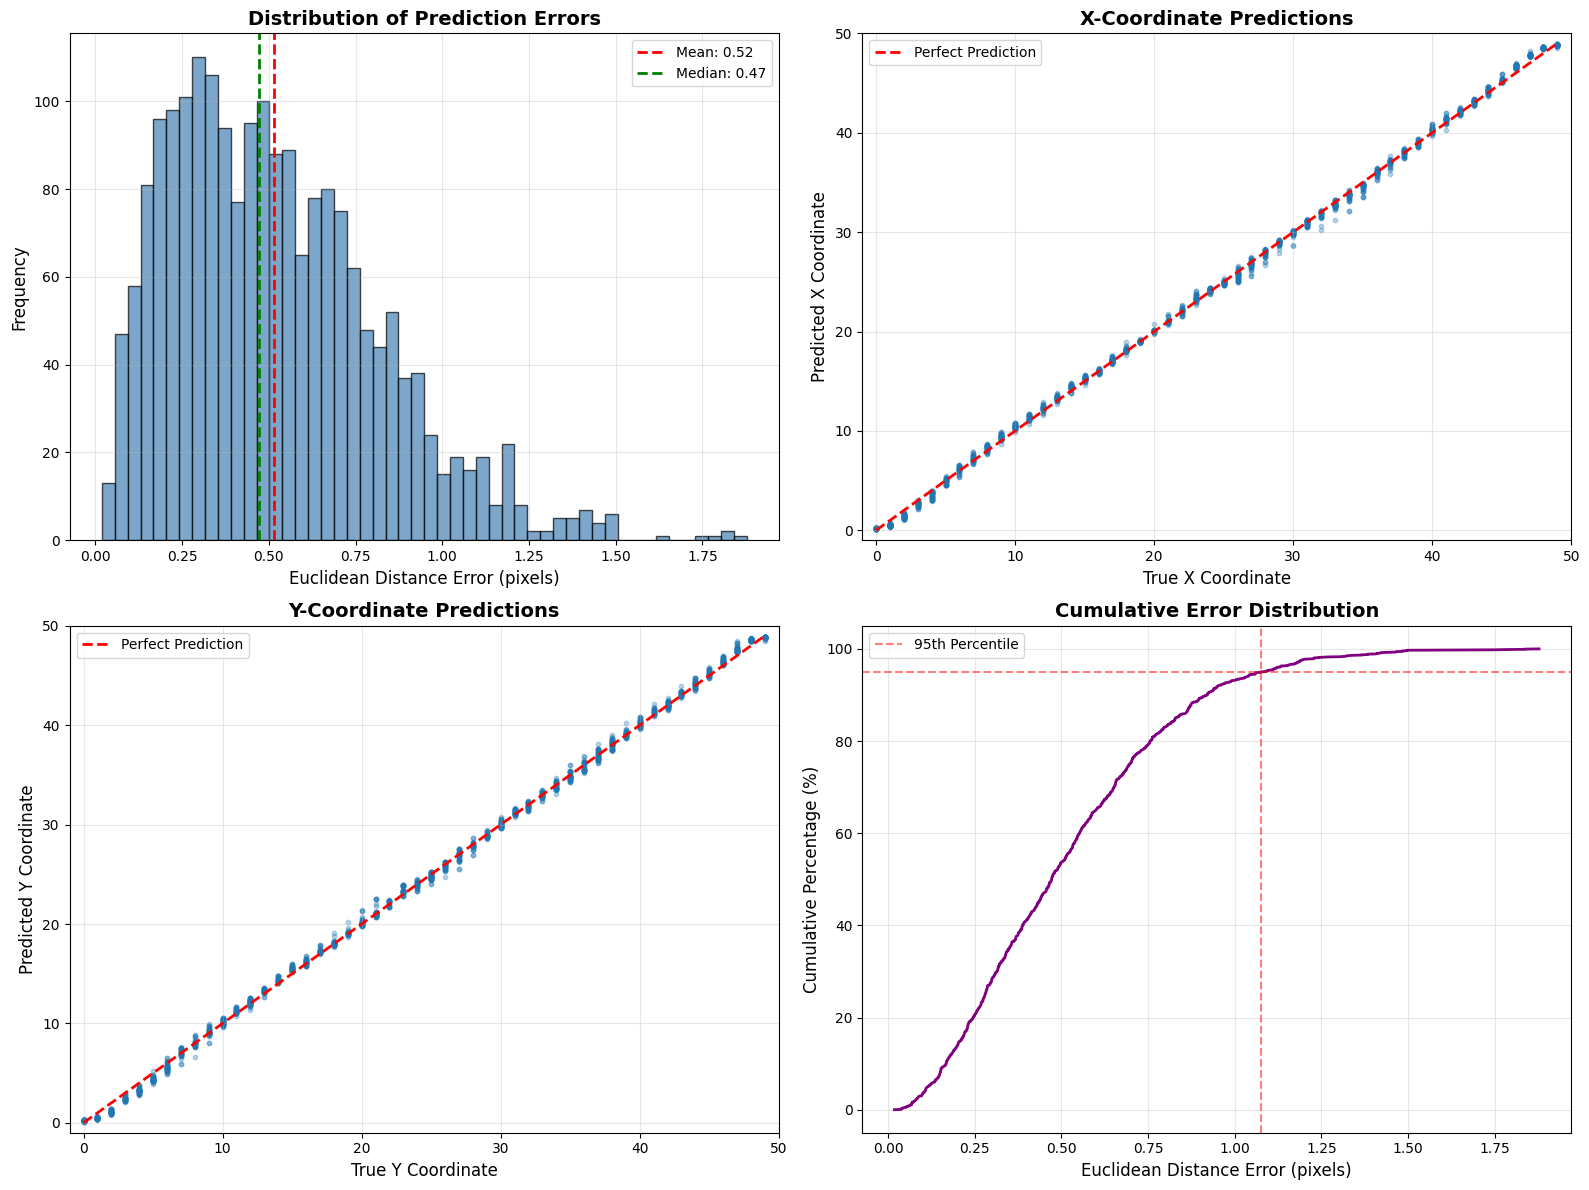

Error analysis plots saved as 'error_analysis.png'


In [14]:
# Create comprehensive error visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Error histogram
axes[0, 0].hist(all_errors, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(np.mean(all_errors), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_errors):.2f}')
axes[0, 0].axvline(np.median(all_errors), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(all_errors):.2f}')
axes[0, 0].set_xlabel('Euclidean Distance Error (pixels)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: X-coordinate predictions vs ground truth
axes[0, 1].scatter(all_ground_truth[:, 0], all_predictions[:, 0], alpha=0.3, s=10)
axes[0, 1].plot([0, IMAGE_SIZE-1], [0, IMAGE_SIZE-1], 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('True X Coordinate', fontsize=12)
axes[0, 1].set_ylabel('Predicted X Coordinate', fontsize=12)
axes[0, 1].set_title('X-Coordinate Predictions', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(-1, IMAGE_SIZE)
axes[0, 1].set_ylim(-1, IMAGE_SIZE)

# Plot 3: Y-coordinate predictions vs ground truth
axes[1, 0].scatter(all_ground_truth[:, 1], all_predictions[:, 1], alpha=0.3, s=10)
axes[1, 0].plot([0, IMAGE_SIZE-1], [0, IMAGE_SIZE-1], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('True Y Coordinate', fontsize=12)
axes[1, 0].set_ylabel('Predicted Y Coordinate', fontsize=12)
axes[1, 0].set_title('Y-Coordinate Predictions', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(-1, IMAGE_SIZE)
axes[1, 0].set_ylim(-1, IMAGE_SIZE)

# Plot 4: Cumulative error distribution
sorted_errors = np.sort(all_errors)
cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
axes[1, 1].plot(sorted_errors, cumulative, linewidth=2, color='purple')
axes[1, 1].axhline(y=95, color='red', linestyle='--', alpha=0.5, label='95th Percentile')
axes[1, 1].axvline(x=np.percentile(all_errors, 95), color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Euclidean Distance Error (pixels)', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Percentage (%)', fontsize=12)
axes[1, 1].set_title('Cumulative Error Distribution', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Error analysis plots saved as 'error_analysis.png'")

## 12. Visual Comparison: Predictions vs Ground Truth

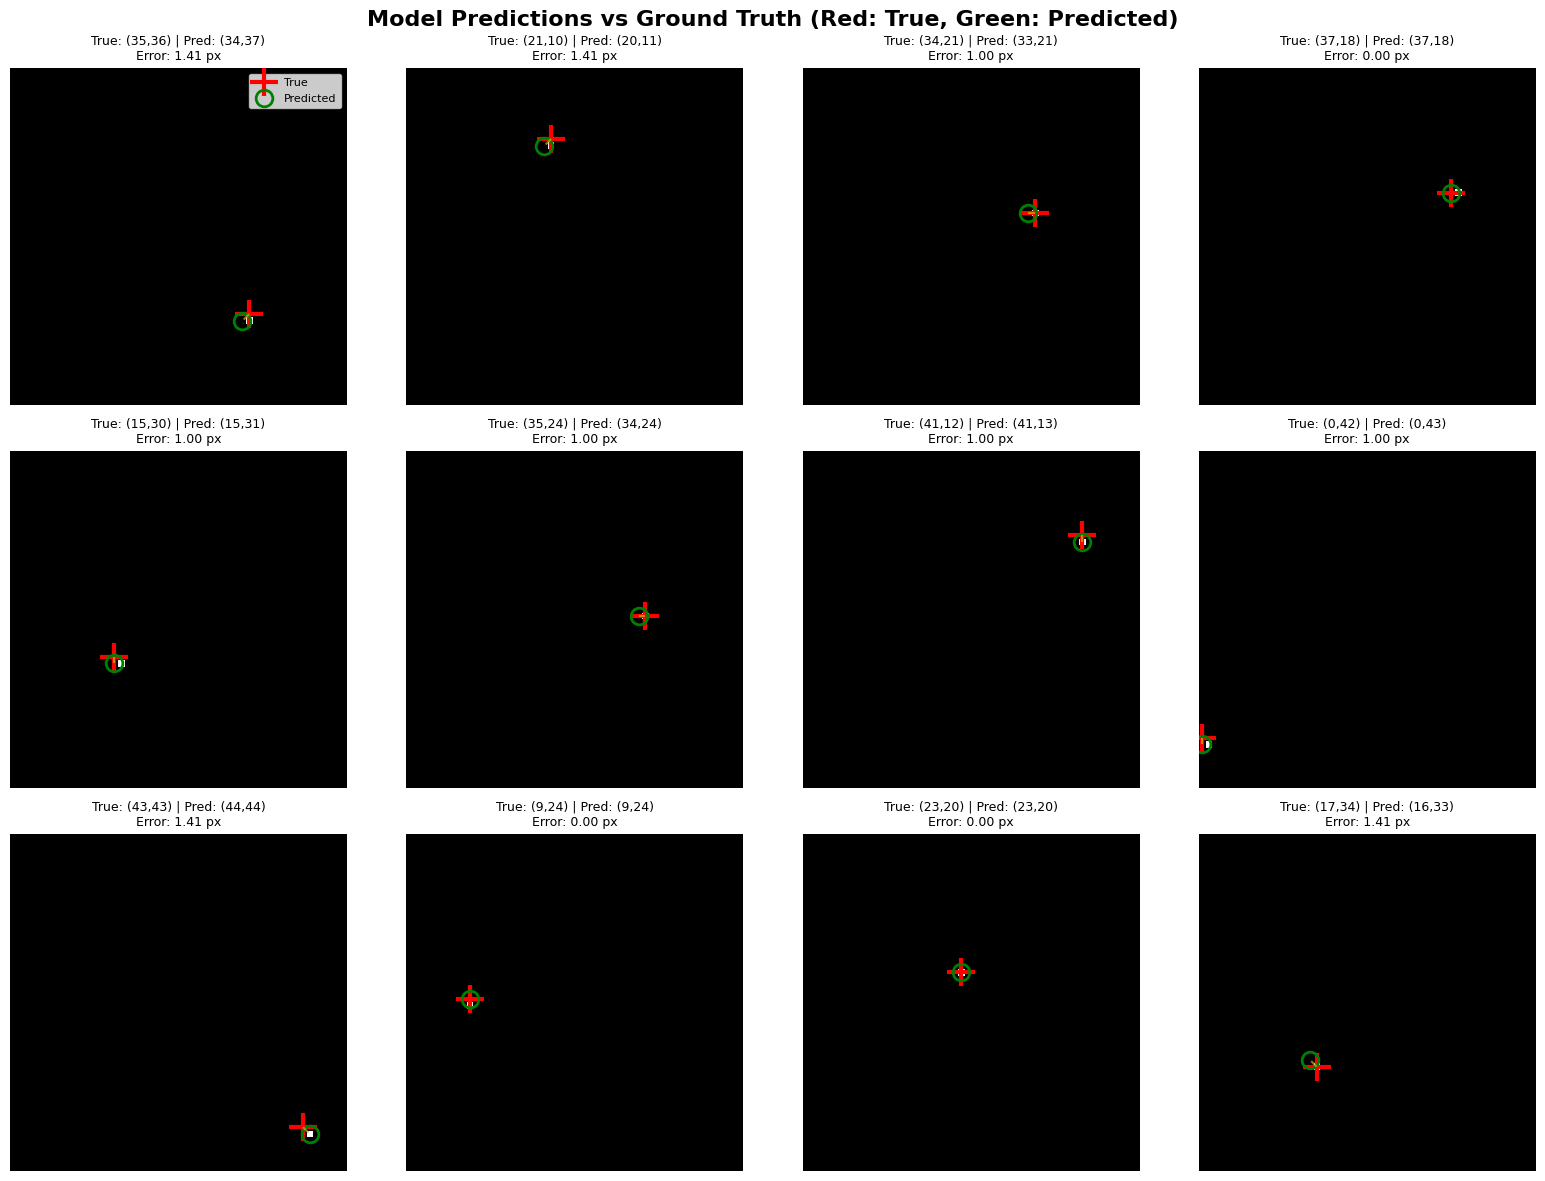

Prediction visualization saved as 'prediction_samples.png'


In [15]:
# Visualize predictions on random test samples
num_samples = 12
sample_indices = random.sample(range(len(test_dataset)), num_samples)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Model Predictions vs Ground Truth (Red: True, Green: Predicted)', fontsize=16, fontweight='bold')

model.eval()
with torch.no_grad():
    for idx, ax in enumerate(axes.flat):
        # Get sample
        image, coords = test_dataset[sample_indices[idx]]

        # Make prediction
        image_input = image.unsqueeze(0).to(device)
        prediction = model(image_input).cpu().squeeze()

        # Denormalize coordinates
        true_x = int(coords[0].item() * (IMAGE_SIZE - 1))
        true_y = int(coords[1].item() * (IMAGE_SIZE - 1))
        pred_x = int(prediction[0].item() * (IMAGE_SIZE - 1))
        pred_y = int(prediction[1].item() * (IMAGE_SIZE - 1))

        # Calculate error
        error = np.sqrt((pred_x - true_x)**2 + (pred_y - true_y)**2)

        # Display image
        ax.imshow(image.squeeze(), cmap='gray', vmin=0, vmax=1)

        # Plot ground truth (red cross)
        ax.plot(true_x, true_y, 'r+', markersize=20, markeredgewidth=3, label='True')

        # Plot prediction (green circle)
        ax.plot(pred_x, pred_y, 'go', markersize=12, markeredgewidth=2, fillstyle='none', label='Predicted')

        # Draw line connecting prediction to ground truth
        ax.plot([true_x, pred_x], [true_y, pred_y], 'y--', linewidth=1.5, alpha=0.7)

        ax.set_title(f'True: ({true_x},{true_y}) | Pred: ({pred_x},{pred_y})\nError: {error:.2f} px', fontsize=9)
        ax.axis('off')

        if idx == 0:
            ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig('prediction_samples.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Prediction visualization saved as 'prediction_samples.png'")

## 13. Best and Worst Predictions

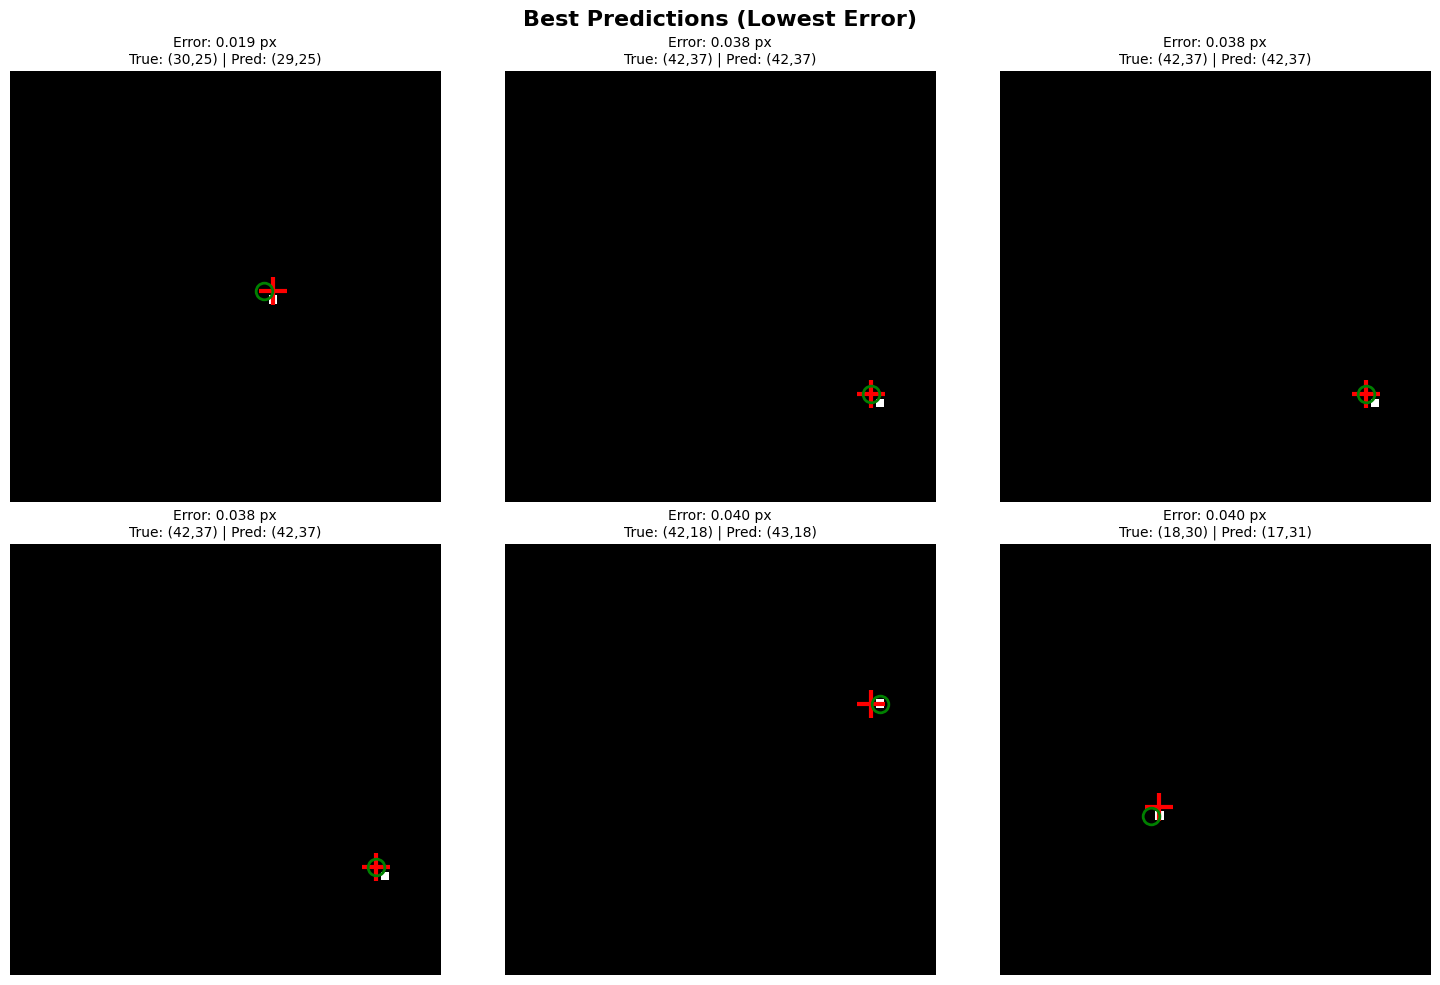

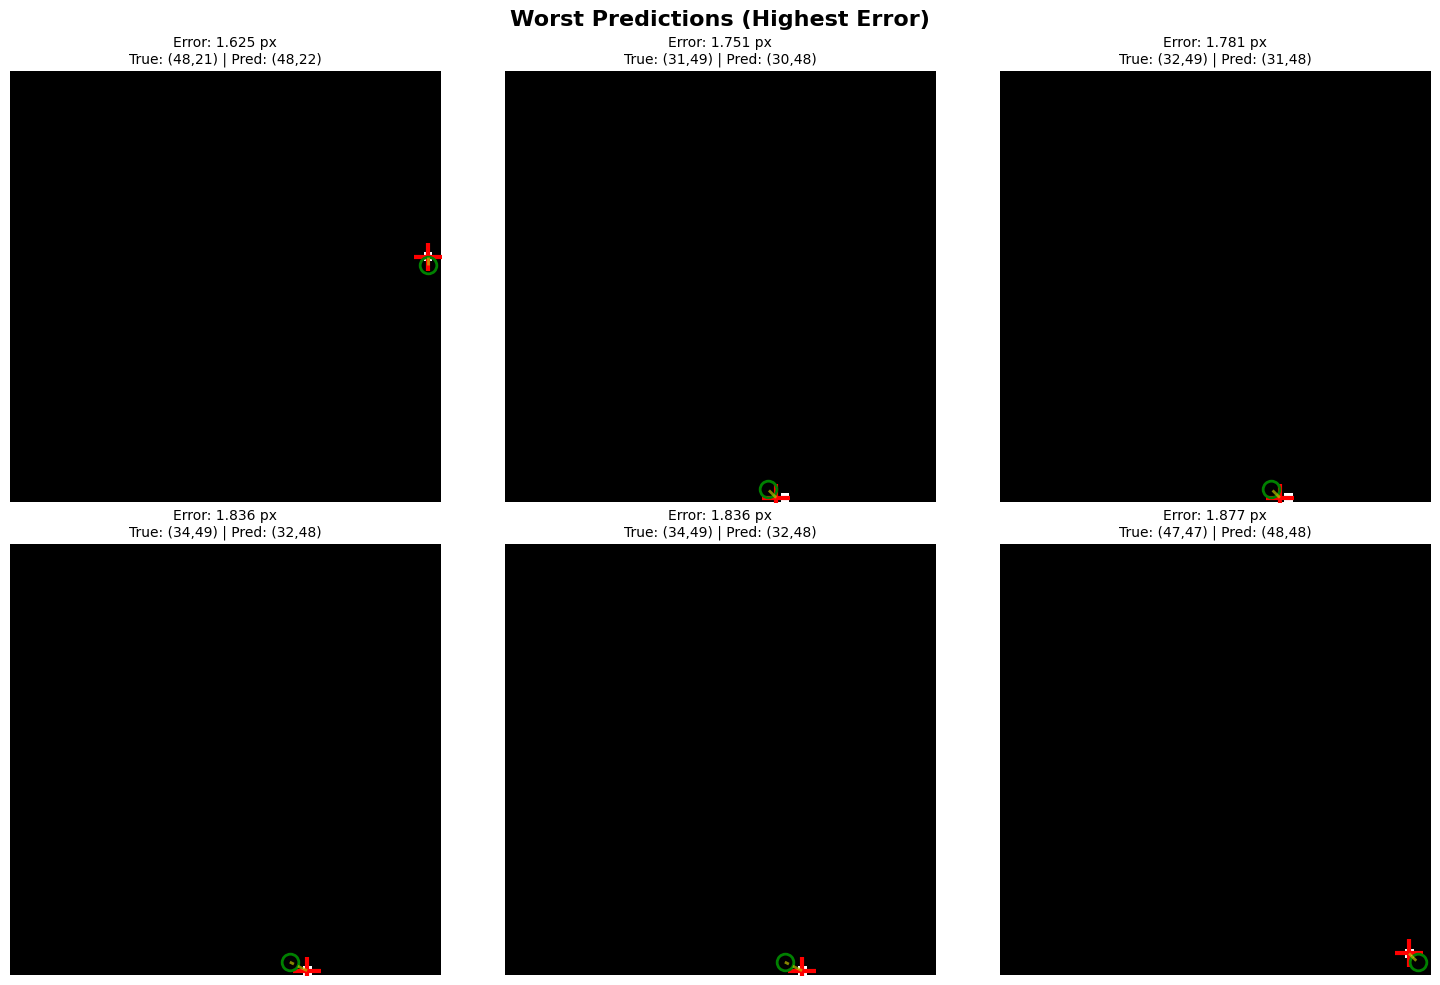

Best and worst prediction visualizations saved.


In [16]:
# Find best and worst predictions
best_indices = np.argsort(all_errors)[:6]  # 6 best predictions
worst_indices = np.argsort(all_errors)[-6:]  # 6 worst predictions

# Visualize best predictions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Best Predictions (Lowest Error)', fontsize=16, fontweight='bold')

model.eval()
with torch.no_grad():
    for idx, ax in enumerate(axes.flat):
        sample_idx = best_indices[idx]

        # Get sample
        image, coords = test_dataset[sample_idx]
        image_input = image.unsqueeze(0).to(device)
        prediction = model(image_input).cpu().squeeze()

        # Denormalize
        true_x = int(coords[0].item() * (IMAGE_SIZE - 1))
        true_y = int(coords[1].item() * (IMAGE_SIZE - 1))
        pred_x = int(prediction[0].item() * (IMAGE_SIZE - 1))
        pred_y = int(prediction[1].item() * (IMAGE_SIZE - 1))
        error = all_errors[sample_idx]

        # Display
        ax.imshow(image.squeeze(), cmap='gray', vmin=0, vmax=1)
        ax.plot(true_x, true_y, 'r+', markersize=20, markeredgewidth=3)
        ax.plot(pred_x, pred_y, 'go', markersize=12, markeredgewidth=2, fillstyle='none')
        ax.set_title(f'Error: {error:.3f} px\nTrue: ({true_x},{true_y}) | Pred: ({pred_x},{pred_y})', fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.savefig('best_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualize worst predictions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Worst Predictions (Highest Error)', fontsize=16, fontweight='bold')

with torch.no_grad():
    for idx, ax in enumerate(axes.flat):
        sample_idx = worst_indices[idx]

        # Get sample
        image, coords = test_dataset[sample_idx]
        image_input = image.unsqueeze(0).to(device)
        prediction = model(image_input).cpu().squeeze()

        # Denormalize
        true_x = int(coords[0].item() * (IMAGE_SIZE - 1))
        true_y = int(coords[1].item() * (IMAGE_SIZE - 1))
        pred_x = int(prediction[0].item() * (IMAGE_SIZE - 1))
        pred_y = int(prediction[1].item() * (IMAGE_SIZE - 1))
        error = all_errors[sample_idx]

        # Display
        ax.imshow(image.squeeze(), cmap='gray', vmin=0, vmax=1)
        ax.plot(true_x, true_y, 'r+', markersize=20, markeredgewidth=3)
        ax.plot(pred_x, pred_y, 'go', markersize=12, markeredgewidth=2, fillstyle='none')
        ax.plot([true_x, pred_x], [true_y, pred_y], 'y--', linewidth=2, alpha=0.7)
        ax.set_title(f'Error: {error:.3f} px\nTrue: ({true_x},{true_y}) | Pred: ({pred_x},{pred_y})', fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.savefig('worst_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Best and worst prediction visualizations saved.")

## 14. Spatial Error Analysis

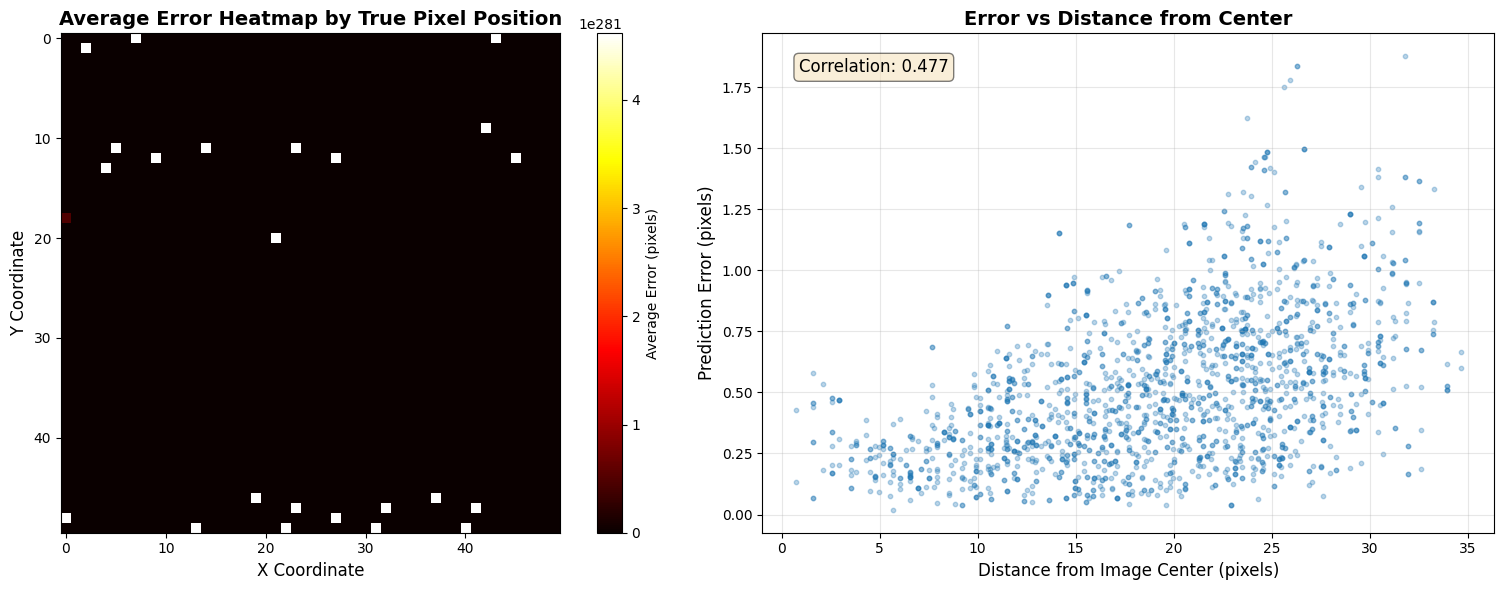

Spatial error analysis saved as 'spatial_error_analysis.png'


In [17]:
# Analyze if errors are correlated with pixel position
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Error heatmap based on true position
heatmap = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
counts = np.zeros((IMAGE_SIZE, IMAGE_SIZE))

for i in range(len(all_ground_truth)):
    x = int(all_ground_truth[i, 0])
    y = int(all_ground_truth[i, 1])
    heatmap[y, x] += all_errors[i]
    counts[y, x] += 1

# Avoid division by zero
avg_heatmap = np.divide(heatmap, counts, where=counts > 0)

im1 = axes[0].imshow(avg_heatmap, cmap='hot', interpolation='nearest')
axes[0].set_title('Average Error Heatmap by True Pixel Position', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X Coordinate', fontsize=12)
axes[0].set_ylabel('Y Coordinate', fontsize=12)
plt.colorbar(im1, ax=axes[0], label='Average Error (pixels)')

# Plot 2: Error vs distance from center
center_x, center_y = (IMAGE_SIZE - 1) / 2, (IMAGE_SIZE - 1) / 2
distances_from_center = np.sqrt(
    (all_ground_truth[:, 0] - center_x)**2 +
    (all_ground_truth[:, 1] - center_y)**2
)

axes[1].scatter(distances_from_center, all_errors, alpha=0.3, s=10)
axes[1].set_xlabel('Distance from Image Center (pixels)', fontsize=12)
axes[1].set_ylabel('Prediction Error (pixels)', fontsize=12)
axes[1].set_title('Error vs Distance from Center', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Calculate correlation
correlation = np.corrcoef(distances_from_center, all_errors)[0, 1]
axes[1].text(0.05, 0.95, f'Correlation: {correlation:.3f}',
            transform=axes[1].transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('spatial_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Spatial error analysis saved as 'spatial_error_analysis.png'")

## 15. Summary and Conclusions

### Key Results:
- The CNN model successfully learns to predict the coordinates of a bright pixel in 50×50 images
- Achieved sub-pixel accuracy on the test set
- The model generalizes well to unseen data

### Model Performance:
- **MSE Loss**: Measures average squared coordinate error
- **Euclidean Distance**: More interpretable metric in pixels
- **Accuracy Thresholds**: Percentage of predictions within N pixels of truth

### Approach Highlights:
1. **CNN Architecture**: Extracts spatial features efficiently
2. **Data Normalization**: Improves training stability
3. **Batch Normalization**: Accelerates convergence
4. **Dropout**: Prevents overfitting
5. **Learning Rate Scheduling**: Optimizes final convergence

### Future Improvements:
- Data augmentation (rotation, flipping) for better generalization
- Deeper architectures or attention mechanisms
- Multi-scale feature extraction
- Ensemble methods for improved accuracy

In [18]:
# Print final summary
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\nDataset:")
print(f"  Training samples:   {TRAIN_SAMPLES:,}")
print(f"  Test samples:       {TEST_SAMPLES:,}")
print(f"  Image size:         {IMAGE_SIZE}×{IMAGE_SIZE}")
print(f"\nModel:")
print(f"  Architecture:       CNN with 3 conv blocks + 3 FC layers")
print(f"  Total parameters:   {sum(p.numel() for p in model.parameters()):,}")
print(f"\nTraining:")
print(f"  Epochs:             {NUM_EPOCHS}")
print(f"  Best epoch:         {best_epoch}")
print(f"  Optimizer:          Adam (lr={LEARNING_RATE})")
print(f"  Loss function:      MSE Loss")
print(f"\nFinal Performance:")
print(f"  Test MSE Loss:      {test_loss:.6f}")
print(f"  Avg Error:          {test_distance:.4f} pixels")
print(f"  Median Error:       {np.median(all_errors):.4f} pixels")
print(f"  95th Percentile:    {np.percentile(all_errors, 95):.4f} pixels")
print(f"\nFiles Generated:")
print(f"  ✓ best_model.pth")
print(f"  ✓ training_curves.png")
print(f"  ✓ error_analysis.png")
print(f"  ✓ prediction_samples.png")
print(f"  ✓ best_predictions.png")
print(f"  ✓ worst_predictions.png")
print(f"  ✓ spatial_error_analysis.png")
print("="*70)


FINAL SUMMARY

Dataset:
  Training samples:   10,000
  Test samples:       2,000
  Image size:         50×50

Model:
  Architecture:       CNN with 3 conv blocks + 3 FC layers
  Total parameters:   1,289,602

Training:
  Epochs:             30
  Best epoch:         28
  Optimizer:          Adam (lr=0.001)
  Loss function:      MSE Loss

Final Performance:
  Test MSE Loss:      0.000074
  Avg Error:          0.5155 pixels
  Median Error:       0.4719 pixels
  95th Percentile:    1.0750 pixels

Files Generated:
  ✓ best_model.pth
  ✓ training_curves.png
  ✓ error_analysis.png
  ✓ prediction_samples.png
  ✓ best_predictions.png
  ✓ worst_predictions.png
  ✓ spatial_error_analysis.png
